In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
pip install Augmentor

In [ ]:
import Augmentor

ModuleNotFoundError: No module named 'Augmentor'

In [ ]:
#train Image
p=Augmentor.Pipeline("/content/drive/My Drive/Potato/Train", output_directory="/content/drive/My Drive/Potato/Train/output")

Initialised with 3844 image(s) found.
Output directory set to /content/drive/My Drive/Potato/Train/output.

In [ ]:
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

p.sample(1000)

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7F55E7FEFD90>: 100%|██████████| 1000/1000 [00:35<00:00, 27.88 Samples/s]


In [ ]:
#test image

q=Augmentor.Pipeline("/content/drive/My Drive/Potato/Test", output_directory="/content/drive/My Drive/Potato/Test/output")

Initialised with 144 image(s) found.
Output directory set to /content/drive/My Drive/Potato/Test/output.

In [ ]:
q.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

q.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

q.sample(1000)

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7F561B101B70>: 100%|██████████| 1000/1000 [00:26<00:00, 37.10 Samples/s]


In [ ]:
#Val Image
r=Augmentor.Pipeline("/content/drive/My Drive/Potato/Val", output_directory="/content/drive/My Drive/Potato/Val/output")
r.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

r.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

r.sample(1000)

Initialised with 1282 image(s) found.
Output directory set to /content/drive/My Drive/Potato/Val/output.

Processing <PIL.Image.Image image mode=RGB size=256x256 at 0x7D9E77747F40>: 100%|██████████| 1000/1000 [00:29<00:00, 34.28 Samples/s]


In [ ]:
data_dir = "/content/drive/My Drive/Potato/Train/output"

data_dir_val = "/content/drive/My Drive/Potato/Val/output"
data_dir_test = "/content/drive/My Drive/Potato/Test/output"

In [ ]:
img_height=224
img_width=224
batch_size=32

import tensorflow as tf


train_ds=tf.keras.utils.image_dataset_from_directory(
     data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle = False,
  image_size=(img_height, img_width),
  batch_size=batch_size,

)


val_ds=tf.keras.utils.image_dataset_from_directory(
     data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = False,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 8000 files belonging to 3 classes.
Using 6400 files for training.
Found 8000 files belonging to 3 classes.
Using 1600 files for validation.


In [ ]:
normalization_layer= tf.keras.layers.Rescaling(1./255)

In [ ]:

!pip install tensorflow
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
base_model = DenseNet201(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# freeze the first 10 layers

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x=Dropout(0.4)(x)
predictions=Dense(3, activation='softmax')(x)
model1=Model(base_model.inputs, outputs=predictions)

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:

!pip install tensorflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout
base_model = ResNet50(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# freeze the first 10 layers


for layer in base_model.layers:
        layer.trainable=False

x=base_model.output
x=GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x=Dropout(0.4)(x)
predictions=Dense(3, activation='softmax')(x)
model2=Model(base_model.inputs, outputs=predictions)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath="/content/drive/MyDrive/model1 -{epoch:03d}-{val_accuracy:.5f}.hdf5"

checkpoint=ModelCheckpoint(
    filepath= model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1

)

model1.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

model2.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.001

                                           )


In [ ]:
history1 = model1.fit(train_ds, epochs=5,
validation_data= val_ds, callbacks=[learning_rate_reduction, checkpoint])

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 3.3240 - accuracy: 0.9286
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/model1 -001-1.00000.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 2342s 12s/step - loss: 3.3240 - accuracy: 0.9286 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 9.4806 - accuracy: 0.8002
Epoch 2: val_accuracy did not improve from 1.00000
200/200 [==============================] - 2323s 12s/step - loss: 9.4806 - accuracy: 0.8002 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 3.9891 - accuracy: 0.7870
Epoch 3: val_accuracy did not improve from 1.00000
200/200 [==============================] - 2331s 12s/step - loss: 3.9891 - accuracy: 0.7870 - val_loss: 1.4968e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/5
200/200 [==============================] - ETA: 0s - loss: 2.2341 - accuracy: 0.7286
Epoch 4: val_accuracy did not improve from 1.00000
200/200 [==============================] - 2337s 12s/step - loss: 2.2341 - accuracy: 0.7286 - val_loss: 0.024

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath="/content/drive/MyDrive/model2 -{epoch:03d}-{val_accuracy:.5f}.hdf5"

checkpoint1=ModelCheckpoint(
    filepath= model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1

)

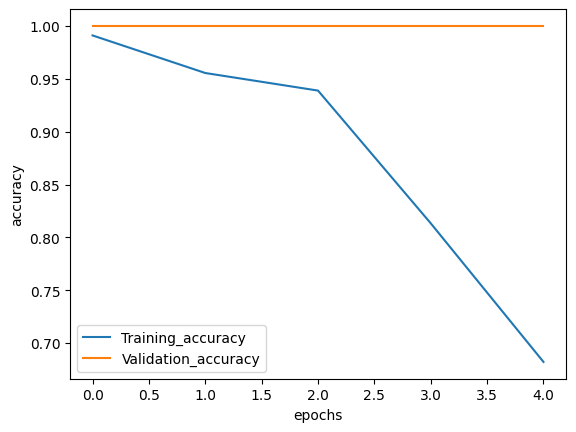

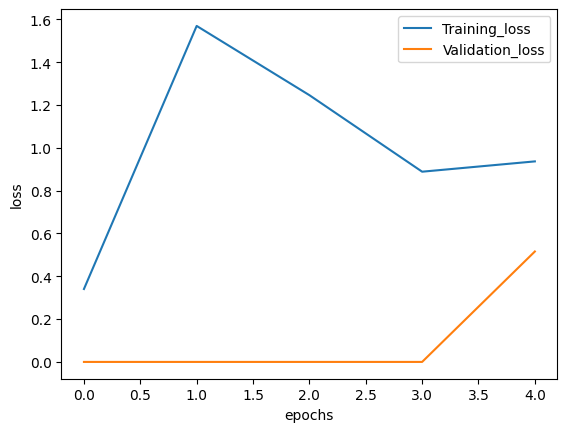

In [ ]:
accs = history1.history['accuracy']
val_accs = history1.history['val_accuracy']
import matplotlib.pyplot as plt

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()


accs1 = history1.history['loss']
val_accs1 = history1.history['val_loss']

plt.plot(range(len(accs1)),accs1, label = 'Training_loss')
plt.plot(range(len(accs1)),val_accs1, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
import numpy as np
y=np.concatenate([val_ds[i][1] for i in range(len(val_ds))])
true_labels=np.argmax(y, axis=-1)
prediction= model1.predict(val_ds, verbose=2)
prediction=np.argmax(prediction, axis=-1)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=true_labels, y_pred=prediction)
cm_plot_labels = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import accuracy_score
acc=accuracy_score(true_labels,prediction)
print('Accuracy: %.3f' % acc)
from sklearn.metrics import precision_score
precision = precision_score(true_labels,prediction,labels=[1,2], average='micro')
print('Precision: %.3f' % precision)
from sklearn.metrics import recall_score
recall = recall_score(true_labels,prediction, average='micro')
print('Recall: %.3f' % recall)
from sklearn.metrics import f1_score
score = f1_score(true_labels,prediction, average='micro')
print('F-Measure: %.3f' % score)

TypeError: '_PrefetchDataset' object is not subscriptable

In [ ]:
train_ds_iter = iter(val_ds)
test_imgs, test_labels = next(train_ds_iter)
print(test_labels)

tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(32,), dtype=int32)


In [ ]:
rounded_labels = np.argmax(test_labels, axis=-1)
print(rounded_labels)

0


In [ ]:
predictions = model1.predict_generator(val_ds, steps=1, verbose=0)
predictions

<ipython-input-30-a627ba65c283>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model1.predict_generator(val_ds, steps=1, verbose=0)


array([[0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.32992947, 0.5970715 , 0.07299902],
       [0.

In [ ]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [ ]:
rounded_labels = np.array(rounded_labels)
rounded_prediction = np.array(rounded_prediction)
y_true=rounded_labels
y_pred=rounded_prediction
print(y_true)
print(y_pred)

NameError: name 'np' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
cm = confusion_matrix(y_true, y_pred)
print(cm)


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    print(tick_marks )
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
   # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    print(cm.shape[0])
    for i in range (3):
      for j in range (3):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

NameError: name 'y_true' is not defined

In [ ]:
history2 = model2.fit(train_ds, epochs=5,
validation_data= val_ds, callbacks=[learning_rate_reduction, checkpoint1])

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 3.2952 - accuracy: 0.9202
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/model2 -001-1.00000.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 1727s 9s/step - loss: 3.2952 - accuracy: 0.9202 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 4.3335 - accuracy: 0.7244
Epoch 2: val_accuracy did not improve from 1.00000
200/200 [==============================] - 1730s 9s/step - loss: 4.3335 - accuracy: 0.7244 - val_loss: 0.0024 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/5
 11/200 [>.............................] - ETA: 20:07 - loss: 4.8103 - accuracy: 0.1619

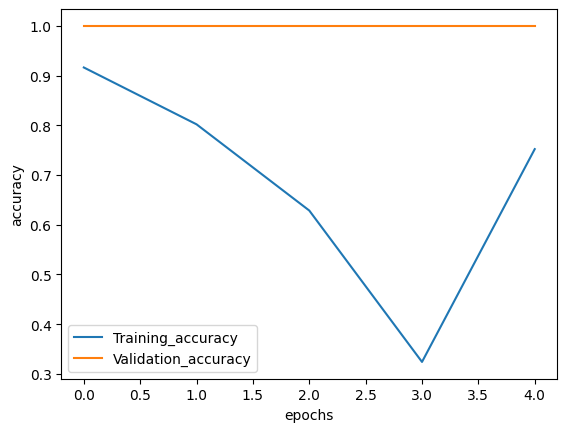

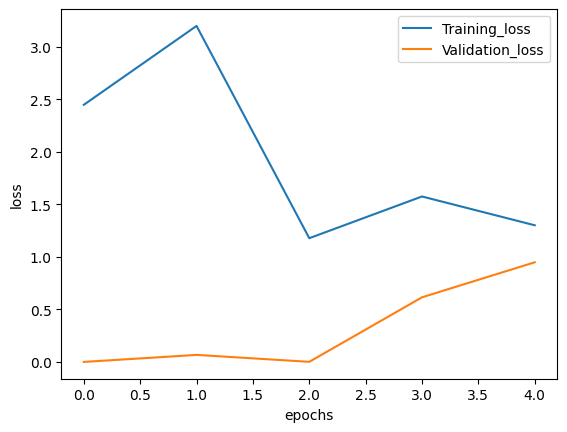

In [ ]:
accs = history2.history['accuracy']
val_accs = history2.history['val_accuracy']
import matplotlib.pyplot as plt

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()


accs1 = history2.history['loss']
val_accs1 = history2.history['val_loss']

plt.plot(range(len(accs1)),accs1, label = 'Training_loss')
plt.plot(range(len(accs1)),val_accs1, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/content/drive/MyDrive/model1 -001-1.00000.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/model2 -001-1.00000.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
models = [model_1, model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

ensemble_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

history3 = ensemble_model.fit(train_ds, epochs=5,
validation_data= val_ds, callbacks=[learning_rate_reduction])




Epoch 1/5
200/200 [==============================] - 2900s 14s/step - loss: 5.0757 - accuracy: 0.2397 - val_loss: 0.6931 - val_accuracy: 0.0256 - lr: 0.0010
Epoch 2/5
200/200 [==============================] - 61s 304ms/step - loss: 1.7446 - accuracy: 0.2858 - val_loss: 0.6931 - val_accuracy: 0.1437 - lr: 0.0010
Epoch 3/5
200/200 [==============================] - 60s 300ms/step - loss: 1.4936 - accuracy: 0.3359 - val_loss: 0.6931 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/5
200/200 [==============================] - 69s 344ms/step - loss: 0.8224 - accuracy: 0.3359 - val_loss: 2.3302e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/5
200/200 [==============================] - 61s 302ms/step - loss: 2.3961 - accuracy: 0.3891 - val_loss: 0.6931 - val_accuracy: 1.0000 - lr: 0.0010


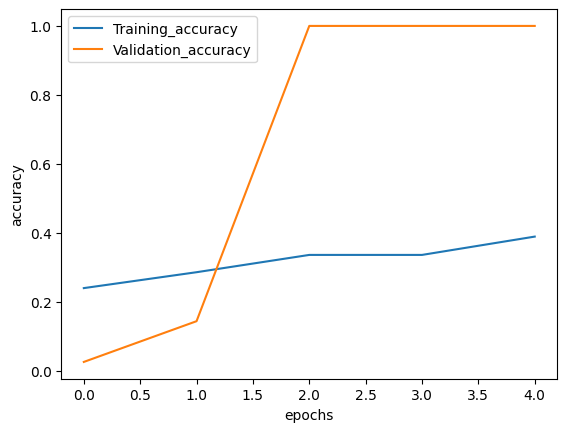

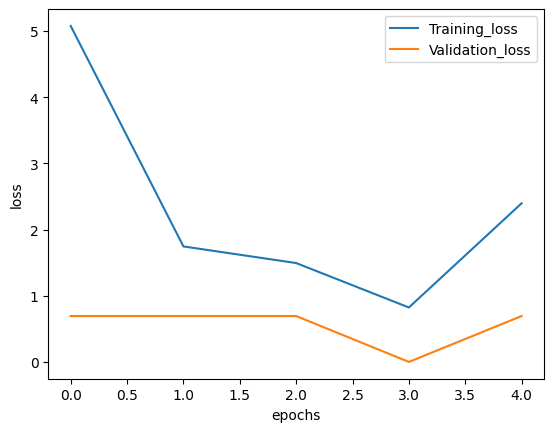

AttributeError: '_PrefetchDataset' object has no attribute 'next'

In [ ]:
accs = history3.history['accuracy']
val_accs = history3.history['val_accuracy']
import matplotlib.pyplot as plt

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()


accs1 = history3.history['loss']
val_accs1 = history3.history['val_loss']

plt.plot(range(len(accs1)),accs1, label = 'Training_loss')
plt.plot(range(len(accs1)),val_accs1, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()






In [ ]:
train_ds_iter = iter(train_ds)
test_imgs, test_labels = next(train_ds_iter)
print(test_labels)

tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int32)


In [ ]:
rounded_labels = np.argmax(test_labels, axis=-1)
print(rounded_labels)

0
